In [102]:
import yaml
from pathlib import Path
from torchvision.ops import boxes
from ultralytics import YOLO
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.patches as patches

In [78]:
def setup_yolo_project(data_yaml_path):
    """
    Setup YOLOv8 project structure and configuration
    """
    # Load the data configuration
    with open(data_yaml_path, 'r') as file:
        data_config = yaml.safe_load(file)

    # Update paths if needed
    base_dir = Path(data_yaml_path).parent
    for key in ['train', 'val', 'test']:
        if key in data_config:
            data_config[key] = str(Path(base_dir) / data_config[key])

    # Save updated config
    with open(data_yaml_path, 'w') as file:
        yaml.dump(data_config, file)

In [79]:
def train_yolo_model(data_yaml_path, epochs=100):
    """
    Train YOLOv8 model with data augmentation
    """
    # Load YOLOv8 nano model
    model = YOLO('yolov8n.pt')

    # Training configuration with augmentation
    config = {
        'data': data_yaml_path,
        'epochs': epochs,
        'imgsz': 640,
        'batch': 16,
        'device': 'cuda:0',  # Use 'cpu' if no GPU available

        # Data augmentation settings
        'augment': True,
        'degrees': 10.0,  # Random rotation
        'translate': 0.1,  # Random translation
        'scale': 0.5,  # Random scaling
        'fliplr': 0.5,  # Horizontal flip probability
        'mosaic': 1.0,  # Mosaic augmentation
        'mixup': 0.5,  # Mixup augmentation

        # Training parameters
        'patience': 50,  # Early stopping patience
        'optimizer': 'auto',
        'lr0': 0.01,  # Initial learning rate
        'lrf': 0.01,  # Final learning rate
        'momentum': 0.937,
        'weight_decay': 0.0005,
        'warmup_epochs': 3.0,
        'warmup_momentum': 0.8,
        'warmup_bias_lr': 0.1,

        # Save best model
        'save': True,
        'save_period': -1,  # Save only best model
    }

    # Start training
    results = model.train(**config)
    return results, model

In [85]:
def evaluate_model(model, data_yaml_path, confidence_threshold=0.25, iou_threshold=0.5):
    """
    Comprehensive model evaluation with detailed metrics
    """
    # Run validation
    metrics = model.val(data=data_yaml_path,
                        conf=confidence_threshold,
                        iou=iou_threshold,
                        verbose=True)

    # Extract detailed metrics
    evaluation_results = {
        'mAP50': metrics.box.map50,  # mAP at IoU=0.50
        'mAP50-95': metrics.box.map,  # mAP at IoU=0.50:0.95
        'precision': metrics.box.mp,  # Mean precision
        'recall': metrics.box.mr,  # Mean recall
        'f1-score': metrics.box.f1,  # F1 score
        'inference_time': metrics.speed['inference'],  # ms per image
        'preprocessing_time': metrics.speed['preprocess'],
        'postprocessing_time': metrics.speed['postprocess']
    }

    print("\nDetailed Evaluation Results:")
    print("-" * 50)
    for metric, value in evaluation_results.items():
        # Check if value is a numpy ndarray
        if isinstance(value, np.ndarray):
            value = value.item()  # Convert to scalar value
        print(f"{metric}: {value:.4f}")

    return evaluation_results

In [81]:
def export_model(model_path, format='tflite'):
    """
    Export the trained model to mobile-friendly formats
    Supported formats: onnx, tflite, coreml
    """
    model = YOLO(model_path)

    # Export the model
    model.export(format=format)

In [82]:
# Replace with your Roboflow dataset path
data_yaml_path = "yolo_data/data.yaml"

# Setup project
setup_yolo_project(data_yaml_path)

In [83]:
# Train model
results, model = train_yolo_model(data_yaml_path)

New https://pypi.org/project/ultralytics/8.3.77 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.76  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=yolo_data/data.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fal

100%|██████████| 5.35M/5.35M [00:00<00:00, 20.1MB/s]


AMP: checks passed 


train: Scanning C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\model_training\yolo_data\train\labels.cache... 876 images, 12 backgrounds, 0 corrupt: 100%|██████████| 876/876 [00:00<?, ?it/s]
val: Scanning C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\model_training\yolo_data\valid\labels.cache... 85 images, 1 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<?, ?it/s]


Plotting labels to C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\runs\detect\train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.99G      1.846      4.027      1.288         27        640: 100%|██████████| 55/55 [00:18<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


                   all         85         88    0.00275      0.795    0.00451    0.00199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.03G      1.616      2.382      1.111         19        640: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]


                   all         85         88      0.795      0.625      0.727      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.03G      1.581      1.923      1.119         27        640: 100%|██████████| 55/55 [00:15<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]


                   all         85         88     0.0104     0.0227    0.00136   0.000617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.02G       1.52      1.677      1.105         26        640: 100%|██████████| 55/55 [00:17<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]

                   all         85         88      0.726      0.591      0.652      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.02G      1.504      1.505      1.097         20        640: 100%|██████████| 55/55 [00:12<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all         85         88      0.615      0.477      0.555      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.01G      1.496      1.426      1.091         20        640: 100%|██████████| 55/55 [00:12<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.52it/s]

                   all         85         88      0.635      0.614      0.664      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.02G        1.5      1.349      1.076         22        640: 100%|██████████| 55/55 [00:12<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         85         88      0.679      0.602      0.642      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.02G      1.511      1.226      1.096         22        640: 100%|██████████| 55/55 [00:11<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]

                   all         85         88      0.773      0.568      0.673      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         2G      1.456      1.198      1.066         32        640: 100%|██████████| 55/55 [00:12<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]

                   all         85         88      0.717      0.633      0.679       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.02G      1.426      1.194      1.046         35        640: 100%|██████████| 55/55 [00:12<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.38it/s]


                   all         85         88      0.725       0.67      0.751       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         2G      1.411      1.178      1.046         29        640: 100%|██████████| 55/55 [00:11<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]

                   all         85         88      0.735      0.819      0.818      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.02G      1.394       1.08      1.051         24        640: 100%|██████████| 55/55 [00:11<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

                   all         85         88      0.871       0.69      0.792      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         2G      1.416      1.109      1.053         24        640: 100%|██████████| 55/55 [00:11<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.39it/s]

                   all         85         88      0.848      0.761      0.886      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         2G      1.374       1.08      1.033         23        640: 100%|██████████| 55/55 [00:11<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

                   all         85         88      0.924      0.727      0.831      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         2G      1.377      1.039      1.047         27        640: 100%|██████████| 55/55 [00:11<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

                   all         85         88      0.761      0.688      0.723      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.02G      1.372      1.042      1.052         24        640: 100%|██████████| 55/55 [00:11<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.35it/s]

                   all         85         88       0.89      0.644      0.815      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         2G       1.34      1.014      1.033         27        640: 100%|██████████| 55/55 [00:11<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.46it/s]

                   all         85         88      0.846       0.75      0.844      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.02G      1.325     0.9611      1.028         26        640: 100%|██████████| 55/55 [00:11<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]

                   all         85         88      0.844      0.807        0.9      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         2G      1.349     0.9955      1.011         26        640: 100%|██████████| 55/55 [00:11<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.19it/s]

                   all         85         88      0.835      0.805      0.868       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.02G      1.302     0.9516      1.021         32        640: 100%|██████████| 55/55 [00:11<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]

                   all         85         88      0.809      0.795      0.863      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         2G       1.33     0.9575       1.02         23        640: 100%|██████████| 55/55 [00:11<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


                   all         85         88      0.948      0.773       0.87      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         2G      1.342     0.9675      1.022         19        640: 100%|██████████| 55/55 [00:11<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         85         88      0.865      0.795      0.857      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         2G      1.362     0.9662      1.036         24        640: 100%|██████████| 55/55 [00:11<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

                   all         85         88      0.921      0.727      0.843      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.02G      1.308     0.9305      1.018         24        640: 100%|██████████| 55/55 [00:11<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

                   all         85         88      0.799      0.815      0.885      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.02G       1.31     0.9313      1.009         24        640: 100%|██████████| 55/55 [00:11<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

                   all         85         88      0.873      0.818      0.874       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.02G      1.296     0.9019      1.016         28        640: 100%|██████████| 55/55 [00:11<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.16it/s]

                   all         85         88      0.854      0.807      0.894       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         2G      1.299     0.9009      1.013         30        640: 100%|██████████| 55/55 [00:11<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

                   all         85         88       0.92      0.784      0.901      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.02G      1.266     0.8851      1.016         41        640: 100%|██████████| 55/55 [00:12<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]

                   all         85         88      0.844       0.83      0.877      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.02G      1.269       0.88      0.985         24        640: 100%|██████████| 55/55 [00:12<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

                   all         85         88      0.949       0.75      0.864      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         2G      1.282     0.8576      1.013         27        640: 100%|██████████| 55/55 [00:12<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.37it/s]

                   all         85         88      0.845      0.716      0.796      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.02G      1.272     0.8632      1.019         28        640: 100%|██████████| 55/55 [00:12<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all         85         88      0.852      0.818      0.896      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.04G      1.294     0.8655     0.9915         27        640: 100%|██████████| 55/55 [00:11<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]

                   all         85         88      0.897      0.818      0.863      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.02G      1.316     0.8761     0.9997         18        640: 100%|██████████| 55/55 [00:11<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

                   all         85         88      0.897      0.818      0.903      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         2G      1.256     0.8352     0.9991         24        640: 100%|██████████| 55/55 [00:11<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

                   all         85         88        0.9      0.816      0.903        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         2G      1.242      0.802     0.9898         27        640: 100%|██████████| 55/55 [00:11<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

                   all         85         88      0.862      0.807      0.905      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.04G      1.277     0.8509      0.999         22        640: 100%|██████████| 55/55 [00:11<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

                   all         85         88      0.898        0.8      0.907       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.02G      1.269     0.8194     0.9923         23        640: 100%|██████████| 55/55 [00:11<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

                   all         85         88      0.863      0.787      0.866      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.02G      1.257     0.8091     0.9803         28        640: 100%|██████████| 55/55 [00:11<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

                   all         85         88      0.978       0.75      0.885      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         2G       1.23     0.8151     0.9835         35        640: 100%|██████████| 55/55 [00:11<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]

                   all         85         88      0.943       0.75      0.897       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.02G      1.249     0.7998     0.9943         23        640: 100%|██████████| 55/55 [00:11<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]

                   all         85         88      0.892      0.843      0.909      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         2G      1.263     0.8226      1.004         19        640: 100%|██████████| 55/55 [00:11<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all         85         88      0.845      0.761      0.828      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.02G      1.225     0.7973     0.9806         26        640: 100%|██████████| 55/55 [00:11<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]

                   all         85         88      0.802      0.852      0.881      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         2G      1.222     0.7826     0.9892         30        640: 100%|██████████| 55/55 [00:11<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.34it/s]

                   all         85         88       0.86      0.841      0.874      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.03G      1.222     0.7517     0.9843         20        640: 100%|██████████| 55/55 [00:11<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

                   all         85         88       0.89      0.795      0.875      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         2G      1.234     0.7621     0.9772         20        640: 100%|██████████| 55/55 [00:11<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

                   all         85         88      0.876       0.83      0.873      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.02G      1.214     0.7808     0.9778         18        640: 100%|██████████| 55/55 [00:11<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.43it/s]

                   all         85         88      0.847       0.82      0.878        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.02G      1.201     0.7599     0.9837         26        640: 100%|██████████| 55/55 [00:11<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]

                   all         85         88      0.851      0.795      0.878      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.02G      1.205     0.7629     0.9794         32        640: 100%|██████████| 55/55 [00:11<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.08it/s]

                   all         85         88      0.868      0.818      0.899      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         2G      1.177     0.7322     0.9654         22        640: 100%|██████████| 55/55 [00:11<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]

                   all         85         88      0.984      0.682      0.868      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         2G      1.223     0.7725      0.979         23        640: 100%|██████████| 55/55 [00:11<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

                   all         85         88      0.876      0.818        0.9      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         2G      1.185     0.7479     0.9655         24        640: 100%|██████████| 55/55 [00:11<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

                   all         85         88      0.881       0.83      0.874       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.02G        1.2     0.7122     0.9752         22        640: 100%|██████████| 55/55 [00:11<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

                   all         85         88      0.921      0.793      0.909      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         2G      1.171      0.745      0.963         27        640: 100%|██████████| 55/55 [00:11<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

                   all         85         88      0.936      0.795       0.92      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         2G      1.178     0.7467     0.9742         21        640: 100%|██████████| 55/55 [00:11<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]

                   all         85         88       0.88      0.864      0.926      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         2G      1.178     0.7236     0.9531         18        640: 100%|██████████| 55/55 [00:11<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]

                   all         85         88      0.867      0.817      0.882      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.02G      1.179     0.7435     0.9671         24        640: 100%|██████████| 55/55 [00:11<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

                   all         85         88      0.913      0.839      0.915      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         2G      1.182     0.7262     0.9693         19        640: 100%|██████████| 55/55 [00:11<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

                   all         85         88      0.791      0.841      0.863      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         2G      1.197     0.7106     0.9709         24        640: 100%|██████████| 55/55 [00:11<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         85         88      0.878       0.83      0.888      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.02G      1.157     0.7092     0.9705         27        640: 100%|██████████| 55/55 [00:11<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]

                   all         85         88      0.928      0.852      0.935      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.02G      1.171     0.7106     0.9592         32        640: 100%|██████████| 55/55 [00:11<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]

                   all         85         88      0.915      0.818       0.92      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.02G      1.178      0.732     0.9682         24        640: 100%|██████████| 55/55 [00:11<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

                   all         85         88      0.936      0.824      0.915      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         2G      1.188     0.7379      0.948         26        640: 100%|██████████| 55/55 [00:11<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.30it/s]

                   all         85         88      0.935      0.814        0.9      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.02G      1.164     0.7312      0.963         25        640: 100%|██████████| 55/55 [00:11<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

                   all         85         88      0.882      0.864      0.919       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.02G      1.132     0.7089     0.9346         36        640: 100%|██████████| 55/55 [00:11<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all         85         88      0.938      0.858      0.918      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         2G      1.156     0.7014     0.9596         28        640: 100%|██████████| 55/55 [00:11<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]

                   all         85         88      0.885      0.871      0.926      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.02G      1.164     0.6965     0.9502         30        640: 100%|██████████| 55/55 [00:11<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         85         88      0.926      0.852      0.928        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.02G      1.149     0.6831     0.9576         20        640: 100%|██████████| 55/55 [00:11<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

                   all         85         88      0.871      0.841      0.919      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.04G      1.138     0.6724     0.9454         26        640: 100%|██████████| 55/55 [00:11<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.58it/s]

                   all         85         88      0.911      0.864      0.931      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.02G      1.134     0.6748     0.9519         30        640: 100%|██████████| 55/55 [00:11<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]

                   all         85         88      0.887      0.852      0.922       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         2G      1.121     0.6833     0.9312         23        640: 100%|██████████| 55/55 [00:11<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]


                   all         85         88      0.961      0.838      0.935      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         2G      1.148     0.6575     0.9526         24        640: 100%|██████████| 55/55 [00:11<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.48it/s]

                   all         85         88      0.924      0.875      0.923      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.02G      1.152     0.6833     0.9547         17        640: 100%|██████████| 55/55 [00:12<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.48it/s]

                   all         85         88      0.887      0.886      0.943      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.02G      1.125     0.6765     0.9406         36        640: 100%|██████████| 55/55 [00:11<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

                   all         85         88      0.898      0.852      0.932      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         2G      1.099     0.6328     0.9417         31        640: 100%|██████████| 55/55 [00:12<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]

                   all         85         88      0.915       0.83      0.917      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.02G      1.131     0.6799     0.9584         24        640: 100%|██████████| 55/55 [00:12<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]

                   all         85         88      0.854      0.867      0.919      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.03G      1.128     0.6576     0.9504         28        640: 100%|██████████| 55/55 [00:11<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]

                   all         85         88       0.94      0.897      0.939       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         2G        1.1      0.649     0.9374         33        640: 100%|██████████| 55/55 [00:12<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

                   all         85         88      0.908      0.864      0.937      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.02G      1.138     0.6568      0.948         26        640: 100%|██████████| 55/55 [00:11<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]

                   all         85         88      0.944      0.841      0.942      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.02G      1.123     0.6474      0.953         23        640: 100%|██████████| 55/55 [00:11<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all         85         88      0.896      0.885      0.941      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.02G      1.088     0.6269     0.9342         33        640: 100%|██████████| 55/55 [00:11<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

                   all         85         88      0.923      0.886      0.935      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         2G      1.099     0.6308     0.9324         31        640: 100%|██████████| 55/55 [00:11<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]

                   all         85         88      0.907      0.891      0.939      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.02G      1.083     0.6238     0.9354         29        640: 100%|██████████| 55/55 [00:11<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

                   all         85         88      0.918      0.886      0.938        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         2G      1.075     0.6331      0.935         25        640: 100%|██████████| 55/55 [00:12<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]

                   all         85         88      0.961      0.818      0.939      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.02G      1.075      0.613     0.9385         22        640: 100%|██████████| 55/55 [00:11<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

                   all         85         88      0.927      0.841      0.934      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         2G      1.074      0.612     0.9158         21        640: 100%|██████████| 55/55 [00:11<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

                   all         85         88      0.895      0.898       0.94      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         2G      1.116     0.6397     0.9313         21        640: 100%|██████████| 55/55 [00:11<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]

                   all         85         88      0.986      0.823      0.943      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         2G      1.048     0.6069     0.9354         25        640: 100%|██████████| 55/55 [00:11<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         85         88      0.895      0.875      0.927      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.04G      1.067     0.6087     0.9319         29        640: 100%|██████████| 55/55 [00:11<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

                   all         85         88      0.937      0.841      0.934      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         2G      1.046     0.5965      0.927         25        640: 100%|██████████| 55/55 [00:11<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

                   all         85         88       0.92      0.864       0.93      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.02G      1.043      0.588     0.9202         33        640: 100%|██████████| 55/55 [00:11<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.22it/s]

                   all         85         88      0.883      0.898       0.94      0.575


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         2G     0.9022     0.4651     0.8966         12        640: 100%|██████████| 55/55 [00:11<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.36it/s]

                   all         85         88      0.896      0.886      0.929      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.02G     0.9196     0.4489     0.8878         13        640: 100%|██████████| 55/55 [00:11<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         85         88      0.894      0.864      0.932      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         2G     0.8815     0.4396     0.8826         15        640: 100%|██████████| 55/55 [00:11<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

                   all         85         88      0.898      0.864      0.929      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         2G     0.8657     0.4279      0.884         13        640: 100%|██████████| 55/55 [00:11<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.12it/s]

                   all         85         88      0.896      0.878      0.928        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         2G     0.8886     0.4366     0.8937         12        640: 100%|██████████| 55/55 [00:11<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.21it/s]

                   all         85         88      0.895      0.875      0.929       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.02G     0.8428     0.4199     0.8762         12        640: 100%|██████████| 55/55 [00:11<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]


                   all         85         88      0.906      0.875      0.928      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         2G     0.8424     0.4227     0.8756         13        640: 100%|██████████| 55/55 [00:11<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.32it/s]

                   all         85         88      0.901      0.875      0.931      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         2G     0.8794     0.4281     0.8834         12        640: 100%|██████████| 55/55 [00:11<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

                   all         85         88      0.884      0.875      0.929      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         2G     0.8691     0.4256     0.8824         11        640: 100%|██████████| 55/55 [00:11<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.52it/s]

                   all         85         88      0.876      0.885      0.926      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.02G     0.8468     0.4128     0.8732         13        640: 100%|██████████| 55/55 [00:11<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

                   all         85         88      0.884      0.863      0.917      0.591



100 epochs completed in 0.388 hours.
Optimizer stripped from C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\runs\detect\train\weights\last.pt, 6.3MB
Optimizer stripped from C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\runs\detect\train\weights\best.pt, 6.3MB

Validating C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\runs\detect\train\weights\best.pt...
Ultralytics 8.3.76  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


                   all         85         88      0.933      0.807      0.934      0.587
Speed: 0.4ms preprocess, 10.7ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\runs\detect\train


In [86]:
# Evaluate model
print("\nRunning model evaluation...")
evaluation_results = evaluate_model(model, data_yaml_path)


Running model evaluation...
Ultralytics 8.3.76  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)


val: Scanning C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\model_training\yolo_data\valid\labels.cache... 85 images, 1 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:11<00:00,  1.95s/it]


                   all         85         88      0.882      0.852      0.921      0.612
Speed: 3.1ms preprocess, 30.4ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\runs\detect\train3

Detailed Evaluation Results:
--------------------------------------------------
mAP50: 0.9214
mAP50-95: 0.6120
precision: 0.8816
recall: 0.8523
f1-score: 0.8667
inference_time: 30.4179
preprocessing_time: 3.1104
postprocessing_time: 2.2719


In [87]:
def visualize_predictions_vs_ground_truth(model, image_path, ground_truth_boxes, ground_truth_labels):
    # Load the image
    img = Image.open(image_path)
    img = np.array(img)

    # Perform predictions using the model
    results = model(image_path)

    # Get predictions
    predictions = results[0].boxes.xyxy.cpu().numpy()
    pred_labels = results[0].boxes.cls.cpu().numpy()
    pred_confidences = results[0].boxes.conf.cpu().numpy()

    # Create figure
    plt.figure(figsize=(12, 8))
    plt.imshow(img)

    # Plot ground truth boxes (blue)
    for gt_box, gt_label in zip(ground_truth_boxes, ground_truth_labels):
        xmin, ymin, xmax, ymax = gt_box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='blue', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(xmin, ymin, f'GT: {gt_label}', color='blue',
                 fontsize=10, verticalalignment='bottom')

    # Plot predicted boxes (red)
    for pred_box, pred_label, pred_conf in zip(predictions, pred_labels, pred_confidences):
        xmin, ymin, xmax, ymax = pred_box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='red', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(xmin, ymin, f'Pred: {int(pred_label)} {pred_conf:.2f}',
                 color='red', fontsize=10, verticalalignment='bottom')

    plt.title("Predictions vs Ground Truth")
    plt.axis('on')
    plt.show()


image 1/1 C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\model_training\yolo_data\test\images\-194-_png.rf.44e00e37b7fb6c14215696375e8755c4.jpg: 640x640 1 bus-number, 134.9ms
Speed: 6.9ms preprocess, 134.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


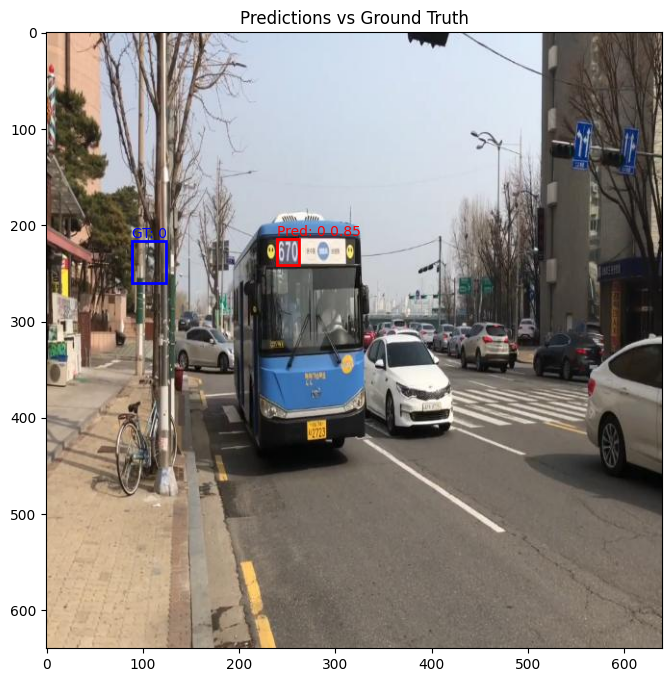


image 1/1 C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\model_training\yolo_data\test\images\-24-_png.rf.99e9f83818a72ac8acccc4c7ea7006e4.jpg: 640x640 1 bus-number, 116.9ms
Speed: 5.9ms preprocess, 116.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


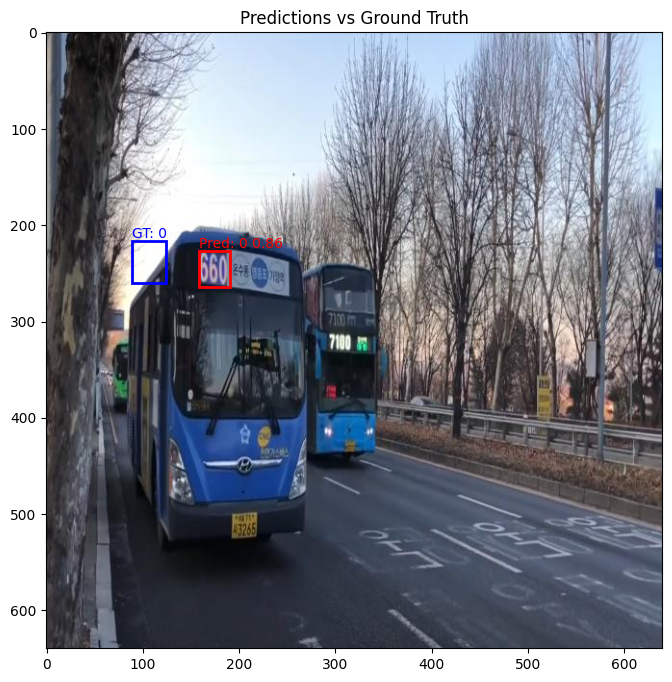


image 1/1 C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\model_training\yolo_data\test\images\-284-_png.rf.ee8b1365de19e1a6b9e17367dccca1e4.jpg: 640x640 1 bus-number, 115.4ms
Speed: 5.7ms preprocess, 115.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


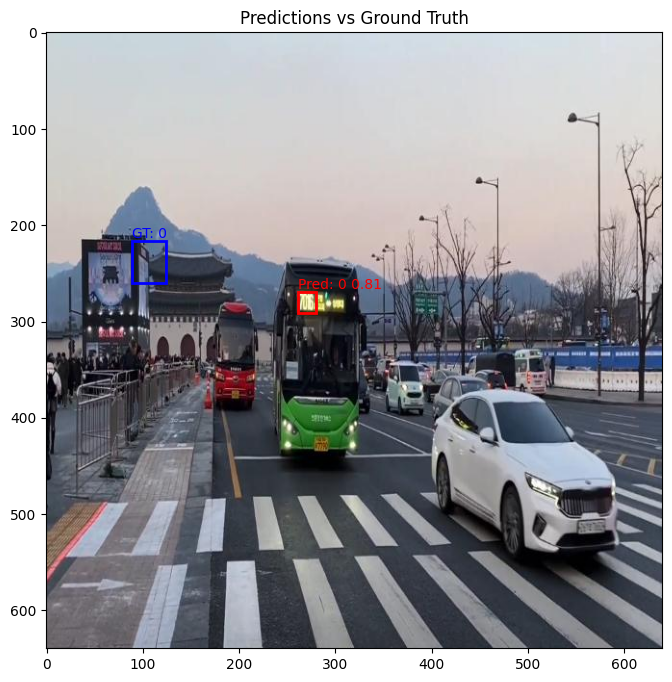


image 1/1 C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\model_training\yolo_data\test\images\-294-_png.rf.820a9ce8c880515204e8a06e86cf5704.jpg: 640x640 2 bus-numbers, 59.9ms
Speed: 4.5ms preprocess, 59.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


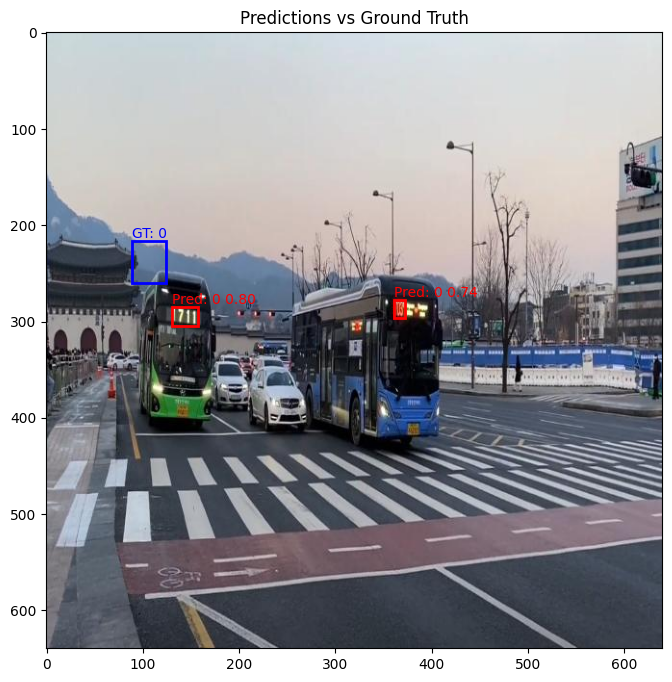


image 1/1 C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\model_training\yolo_data\test\images\-297-_png.rf.2916b31298c31bdde992638086e0c9cd.jpg: 640x640 1 bus-number, 62.9ms
Speed: 5.6ms preprocess, 62.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


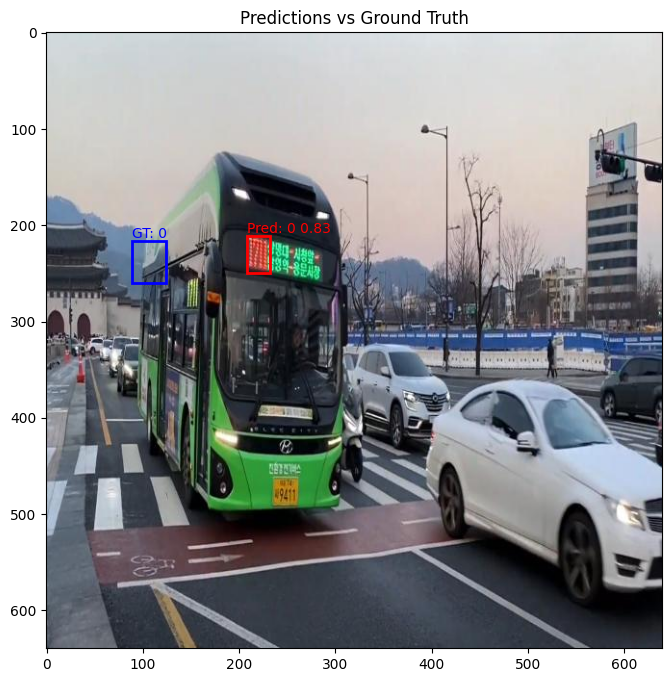


image 1/1 C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\model_training\yolo_data\test\images\-319-_png.rf.61c1d06825780ec60c6af121e89b3d80.jpg: 640x640 1 bus-number, 62.3ms
Speed: 5.0ms preprocess, 62.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


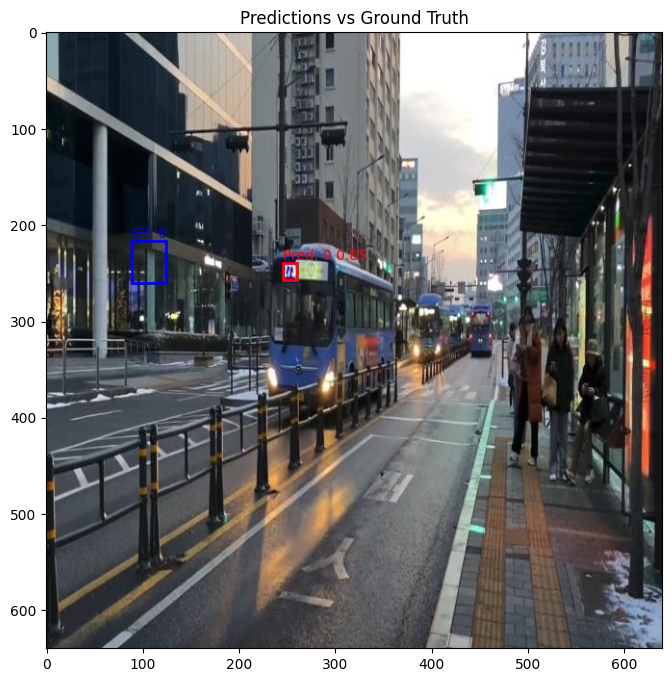


image 1/1 C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\model_training\yolo_data\test\images\-87-_png.rf.cca0a3be715631459a44ea433598e5cb.jpg: 640x640 2 bus-numbers, 59.6ms
Speed: 4.2ms preprocess, 59.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


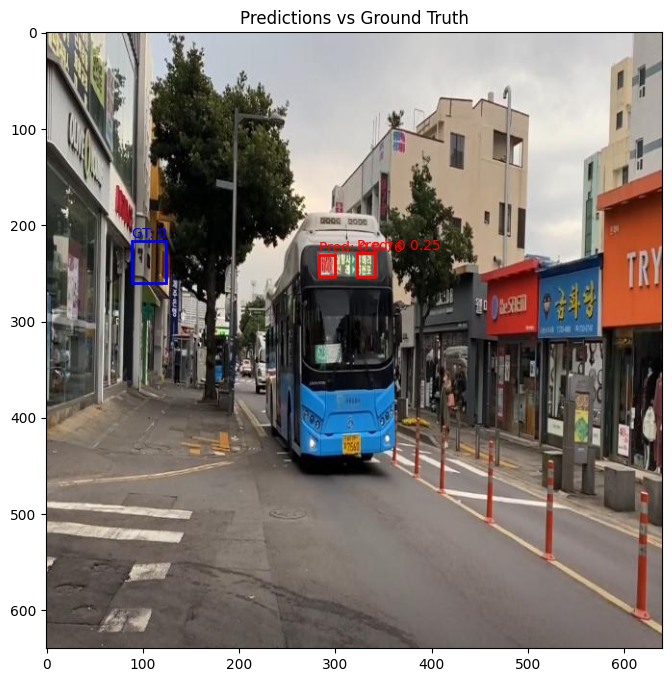


image 1/1 C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\model_training\yolo_data\test\images\-91-_png.rf.dcdca178d5659668bd3ccd3e692d2527.jpg: 640x640 1 bus-number, 60.8ms
Speed: 4.5ms preprocess, 60.8ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)


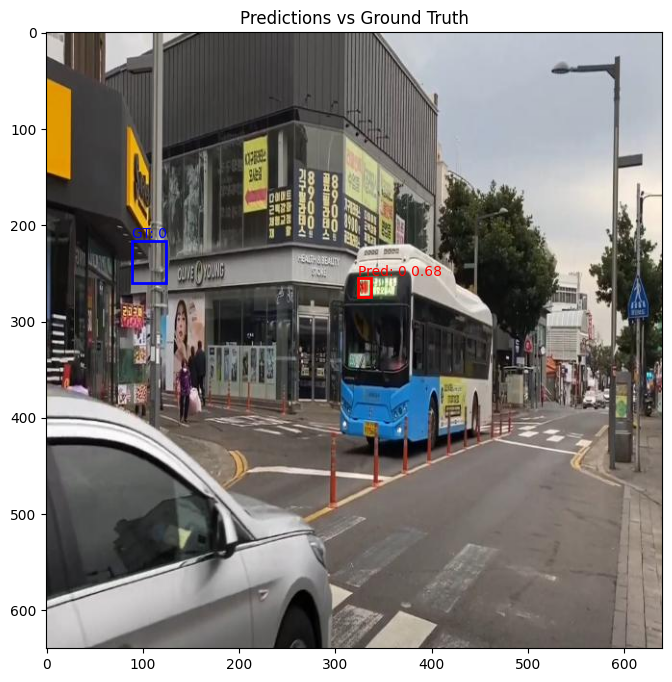


image 1/1 C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\model_training\yolo_data\test\images\1-fvg-757-vdl-citea-de-lijn-216513_jpg.rf.c1ac50736ace06cd66cda6ec958424d9.jpg: 640x640 1 bus-number, 60.4ms
Speed: 4.4ms preprocess, 60.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


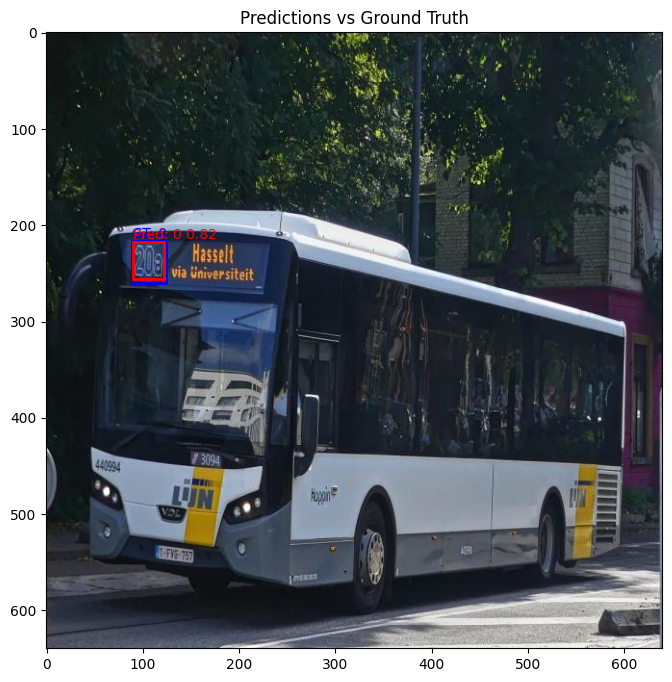


image 1/1 C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\model_training\yolo_data\test\images\1-rlx-137-vdl-citea-de-lijn-212962_jpg.rf.25d4a8af5d05411179d66844a084b20c.jpg: 640x640 1 bus-number, 60.2ms
Speed: 5.0ms preprocess, 60.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


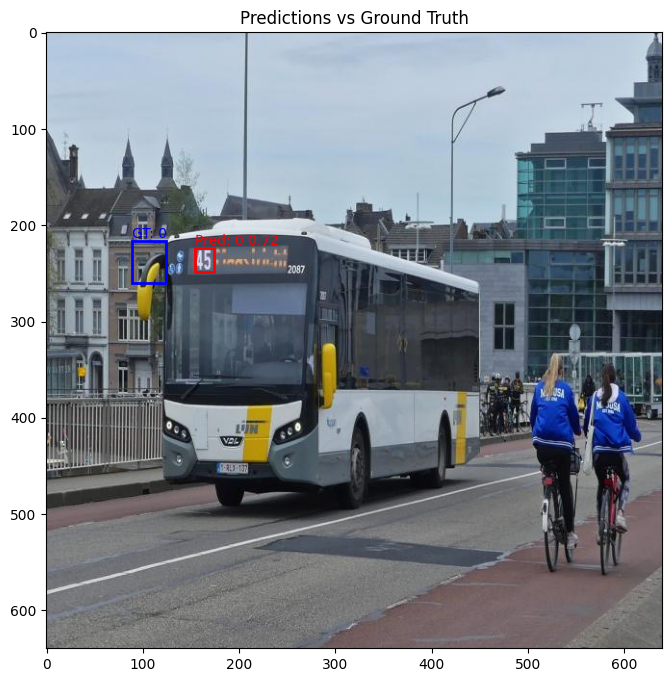

In [97]:
# Example usage
# Assume the model is loaded, and you have the path, ground truth boxes, and labels.
image_path = "test_bus_3.jpg"
images_path = "yolo_data/test/images"
ground_truth_boxes = [[88.25, 216.0, 123.75, 260.0]]
# i = 0
# for image in Path(images_path).glob("*.jpg"):
#     visualize_predictions_vs_ground_truth(model, image, ground_truth_boxes=ground_truth_boxes,
#                                           ground_truth_labels=[0])
#     i+=1
#     if i == 10:
#         break

# Example ground truth boxes and labels (xmin, ymin, xmax, ymax)
# Visualize
# visualize_predictions_vs_ground_truth(model, image_path, ground_truth_boxes, [0])

In [67]:
# Save evaluation results
output_dir = Path("../runs/detect/train")
evaluation_file = output_dir / "args.yaml"
with open(evaluation_file, 'w') as f:
    yaml.dump(evaluation_results, f)

In [103]:
# Export model for mobile deployment
best_model_path = "../runs/detect/train/weights/own_bus_weights.pt"
export_model(best_model_path,)  # For Android

Ultralytics 8.3.76  Python-3.12.7 torch-2.5.1+cu121 CPU (12th Gen Intel Core(TM) i7-12650H)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '..\runs\detect\train\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)

TensorFlow SavedModel: starting export with tensorflow 2.18.0...

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.48...
ONNX: export success  4.9s, saved as '..\runs\detect\train\weights\best.onnx' (11.8 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.26.3...
TensorFlow SavedModel: export failure  62.7s: No module named 'imp'


ModuleNotFoundError: No module named 'imp'